
## AZURE DATA ENGINEERING REAL-TIME PROJECT
### ADVENTURE WORKS SALES

- The data source: On-premise SQL Server Database.  
- A major requirement for this project is migrating the data from the on-prem SQL server database to the cloud. 

#### Tools
- Microsoft SQL Server Manager Studio
- Azure Data Factory (ADF)
- Azure Synapse Analytics
- Azure Data Bricks
- Azure Data Lake 
- Azure Active Directory
- Azure Key Vault
- Power BI Desktop  
  

#### THE ARCHITECTURE USED  
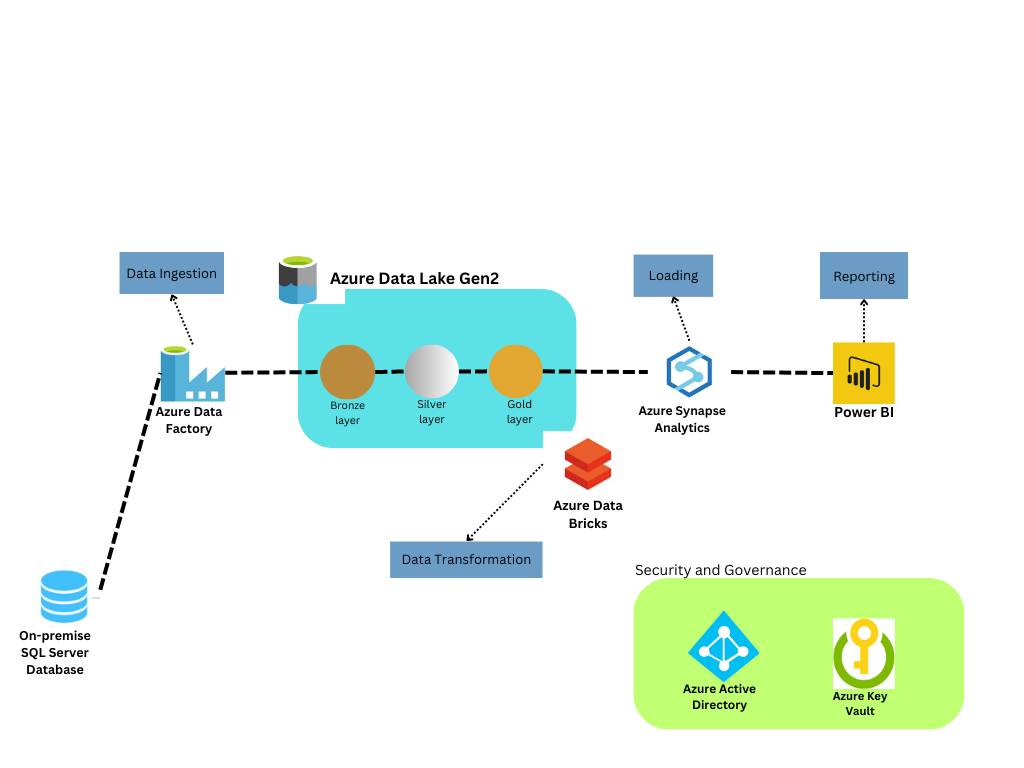

## Data Ingestion: Azure Data Factory (ADF)
The first step in the migration process is using ADF, an ETL tool for data ingestion. I will connect this tool to the on-premise SQL database to copy all the tables from the database and move them to the cloud. I will also use ADF to put the copied tables into the azure data lake gen 2 storage.

## Storage in the Cloud
#### Azure Data Lake Gen 2.
#### The Lake House Architecture. 
There are three layers here, the bronze layer, the silver layer, and the gold layer. When the ADF copies the data from the on-prem SQL server to the data lake, it first puts it in the bronze layer. The bronze layer usually holds the original form of the data. That is because during later transformation, if something goes wrong with the data, the data in the bronze layer, which is the original form, will be available. There is also a silver layer that contains data with some transformation and a gold layer that contains the cleanest data.

## Transformation
#### Azure Databricks
Databricks is a tool for transforming all the raw data into the most curated form, and it makes the active development work possible using Python, Pyspark, SQL, etc. Use the tool to connect to the bronze layer of the data lake, perform some transformation, and load the transformed data into the silver layer.  Do the same for the silver layer transformation and load the cleanest data into the gold layer.

## Loading
#### Azure Synapse Analytics
We will create the database here and load the tables from the data lake gold layer into synapse analytics. At this point, the data migration to the cloud will be complete. The data at this stage is ready for analysis and reporting.

## Reporting
#### Power BI
Load the data for analysis from azure synapse analytics. Do further transformation can here if necessary. Power BI allows the creation of visualisation reports and dashboards.


## Security and Governance
#### Azure Active Directory
Identity access management tool for security matters and creating service principles.

#### Azure Key Vault
For storing secrets, i.e., usernames and passwords.







## ENVIRONMENT
It is imperative to open an account in the Azure portal, create a resource group and then create all the resources necessary for the completion of this project.
- Azure free account/subscription
- Resource group
- Azure Data Factory
- Databricks
- Key Vault
- Data Lake gen 2
- Synapse Analytics
- The data source is the on-prem SQL server database on my computer. I have an existing server in which I create a database (Adventure Works LT 2022), an open-source database. I will be moving the SalesLT schema tables.
- There is no initial connection between this database and azure, but as part of the ingestion process, I need to establish a connection between SQL server and the cloud. I create login credentials for this database. 


In [ ]:
%sql
CREATE LOGIN **** WITH PASSWORD = '*********';

create user **** for login ****

The username and password will enable login and connection in azure. I also assign ‘db_datareader’ role so that the new user has reader access to all the tables in the database. All credentials (usernames and passwords) go into the azure key vault for safety and easy access.  
A quick view of all the available SalesLT schema tables in the SQL server database that I want to copy:

In [ ]:
%sql
SELECT
s.name AS SchemaName,
t.name AS TableName
FROM sys.tables t
INNER JOIN sys.schemas s
ON t.schema_id = s.schema_id
WHERE s.name = 'SalesLT'

## Data Ingestion: Azure Data Factory
In the newly launched ADF studio, establishing the connection to the on-prem data source is crucial and possible by installing a self-hosted integration runtime on the device with the database. By default there is an Azure integrated runtime for connecting to cloud base resources. Two things are necessary to perform any operation. The compute power and the infrastructure to execute that operation. The self-hosted integration runtime provides the compute power and the infrastructure for the data factory to perform the o. After downloading the self-hosted integration runtime, the connection is running, and the link between the data factory and my local machine is complete. For the data injection, I connect to the on-premise SQL server database to copy the data using the ADF. Steps:

- Create a Pipeline and insert a Lookup activity. This activity will contain the SQL query for viewing the tables in the on-premise SQL server.
- Create a ForEach activity that connects to the lookup activity and runs on the success of the LookUp activity. The ForEach activity iterates through the items in the output of the LookUp activity.
- In the ForEach activity, add a Copy data activity. I carefully configure the Source and the Sink. In the source, this involves creating linked services to connect to the data source, selecting the self-hosted integration run time, adding the server name and database name, selecting the authentication type, creating an azure key vault linked service and using the key vault to retrieve the password, and using the below SQL query to get the schema name and the table name from the Lookup activity:

In [ ]:
%sql
@{concat('SELECT * FROM ', item().SchemaName, '.', item().TableName)}

Upon running the pipeline each item will pass through the ForEach activity loop. The ForEach activity loop will get the SchemaName and the TableName and use them  the Copy data activity source in the defined query. The process will happen iteratively, until it copies all the tables.  

In the sink, I create a new sink dataset for the data lake to put the data. I do this by creating a new data set, selecting azure data lake gen 2, and selecting the format (parquet in this case). I name the dataset, select the linked service connection, and then select the bronze container for the file path.

#### The bronze container folder structure:
‘Bronze/SalesLT/Address/Address.parquet’. These are the container, the schema name, the directory, and the file name respectively.

When copying the tables into the bronze container, the tables will be in this folder structure.  
- I use the 'item().SchemaName' and 'item().TableName' from the source in the sink dataset. I create parameters for them and give them values from the item values. I use the two parameter values to generate the folder structure.  
- Upon the successful run of the pipeline, the tables are visible in the SalesLT folder (the schema name), which is in the data lake bronze container. Each table in the folder has a directory structure and the directory structure, corresponding parquet files.  
- After connecting to the on-prem SQL server, the tables are now visible. The sink configuration moves the data from the source to the azure data lake storage (bronze layer). Upon proper setup, the copy activity is ready.  


## Data Transformation: Azure Databricks

This is the transformation/ cleaning phase of this data engineering project. The Databricks tool lets me:  
- Create a compute cluster and configure it as desired for desired performance bearing cost in mind.  
- To enable credential passthrough for user-level data access, which allows me connect to the data lake through the user account with the blob storage - contributor access.  
- To use databricks to access and process the data from the data lake, I use a set of codes to mount the data lake. The codes used in the notebook are python codes.  
- To create the mount points for the bronze container:  


In [ ]:
configs = {
   "fs.adl.oauth2.access.token.provider.type": "CustomAccessTokenProvider",
   "fs.adl.oauth2.access.token.custom.provider": spark.conf.get("spark.databricks.passthrough.adls.tokenProviderClassName")
   }

# Optionally, you can add <directory-name> to the source URI of your mount point. Test in the source is the bronze container, followed by the storage account name. Update the mount_point name to access the data in the brinze container.
dbutils.fs.mount(
   source = "wasbs://test@storagedemo.blob.core.windows.net/",
   mount_point = "/mnt/test1",
   extra_configs = {'fs.azure.account.key.storagedemo.blob.core.windows.net':'1Sj2vKXhEG2L3KVUJ+yMYwB+ddDSc5LC0n+1Tqb6vc1a/ECKH9hn/ehJsAYuRoGceOfy7N2PbuSX+ASt5EAUug=='})


In [ ]:
#To view all the files inside the SalesLT folder
dbutils.fs.ls("/mnt/test1/SalesLT/")

I also create mount points for the silver and gold containers. These two are initially empty, but it is more efficient to mount them at first. The mount points allow for access of the data in the containers.
Mount point for the silver container:

In [ ]:
configs = {
   "fs.adl.oauth2.access.token.provider.type": "CustomAccessTokenProvider",
   "fs.adl.oauth2.access.token.custom.provider": spark.conf.get("spark.databricks.passthrough.adls.tokenProviderClassName")
   }

# Optionally, you can add <directory-name> to the source URI of your mount point.
dbutils.fs.mount(
   source = "wasbs://silver@storagedemo.blob.core.windows.net/",
   mount_point = "/mnt/silver",
   extra_configs = {'fs.azure.account.key.storagedemo.blob.core.windows.net':'1Sj2vKXhEG2L3KVUJ+yMYwB+ddDSc5LC0n+1Tqb6vc1a/ECKH9hn/ehJsAYuRoGceOfy7N2PbuSX+ASt5EAUug=='})


Mount point for the gold container:

In [ ]:
configs = {
   "fs.adl.oauth2.access.token.provider.type": "CustomAccessTokenProvider",
   "fs.adl.oauth2.access.token.custom.provider": spark.conf.get("spark.databricks.passthrough.adls.tokenProviderClassName")
   }

# Optionally, you can add <directory-name> to the source URI of your mount point.
dbutils.fs.mount(
   source = "wasbs://gold@storagedemo.blob.core.windows.net/",
   mount_point = "/mnt/gold",
   extra_configs = {'fs.azure.account.key.storagedemo.blob.core.windows.net':'1Sj2vKXhEG2L3KVUJ+yMYwB+ddDSc5LC0n+1Tqb6vc1a/ECKH9hn/ehJsAYuRoGceOfy7N2PbuSX+ASt5EAUug=='})


I use the bronze mount point to read the data in the bronze container, perform the first level transformation, and load the transformed data into the silver container using the silver mount point. I then use the silver mount point to read the data in the silver container, perform further transformation, and load the most curated form of the data into the gold container using the gold mount point.  

#### The Transformation
The data in SSMS (On-prem DB) is structured and slightly clean. Thus, only minimal transformation is needed.  
The data columns across all tables are in date-time format. The required format is the date format. I will transform all data-time columns to date columns using Pyspark in Databricks.  

#### Bronze to Silver Transformation


In [ ]:
#To connect to the bronze container to get the data
dbutils.fs.ls('/mnt/test1/SalesLT')

#Viewing the silver container shows that it is currently empty before the transformation
dbutils.fs.ls('/mnt/silver/')


In [ ]:
table_name = []

#for each loop to iterate through the bronze (test1) container, get the directory name, and append the directory name to the table name. All the directory names under the bronze container will get added as a table name to the table_name array
for i in dbutils.fs.ls('mnt/test1/SalesLT/'):
    table_name.append(i.name.split('/')[0])


In [ ]:
#The table_name array shows the tables inside the bronze container
table_name

In [ ]:
from pyspark.sql.functions import from_utc_timestamp, date_format
from pyspark.sql.types import TimestampType

#The loop iterates through the table_name array. The code uses the mount location for the bronze container, and generates the path using the table name from the for each loop. Then load the iterated input path as a data frame. The column variable gets all the column names from the data frame as a list.

for i in table_name:
    path = '/mnt/test1/SalesLT/' + i + '/' + i + '.parquet'
    df = spark.read.format('parquet').load(path)
    column = df.columns

#Iterate through the column names to check for values called Date or date. Those columns will be transformed from date-time to date format.
    for col in column:
        if "Date" in col or "date" in col:
            df = df.withColumn(col, date_format(from_utc_timestamp(df[col].cast(TimestampType()),"UTC"), "yy-MM-dd"))

#Output path to the silver container and write the transformed data frame to the data lake using the output path in delta format
    output_path = '/mnt/silver/SalesLT/' + i + '/'
    df.write.format('delta').mode("overwrite").save(output_path)


The delta format allows tracking of version history and can handle future schema changes. It is recommended to use this format in Databricks.

In [ ]:
#Display df of the last item in the list
display(df)

#### Silver to Gold Transformation
Here, I perform a naming convention transformation, changing the column names from a pascal case format to a snake case format.

In [ ]:
#List variable will be populated by the tables in the silver container
table_name = []

for i in dbutils.fs.ls('mnt/silver/SalesLT/'):
    table_name.append(i.name.split('/')[0])


In [ ]:
#View tables in the silver container
table_name

In [ ]:
#Use the list to iterate through the for each loop
for name in table_name:
    path = '/mnt/silver/SalesLT/' + name
    print(path)
    df = spark.read.format('delta').load(path)

    #To get the list of the column names
    column_names = df.columns

    for old_col_name in column_names:
        #convert the names in each column from pascal format (ColumnName) to snake format (column_name)
        new_col_name = "".join(["_" + char if char.isupper() and not old_col_name[i-1].isupper() else char for i, char in enumerate(old_col_name)]).lstrip("_")

        #change the name of the column using withColumnRenamed and regexp_replace
        df = df.withColumnRenamed(old_col_name, new_col_name)

    output_path = '/mnt/gold/SalesLT/' + name + '/'
    df.write.format('delta').mode("overwrite").save(output_path)

#Display final data frame
display(df)


The final transformation is complete, and the data is ready to be loaded into the database and used for reporting.  
The two levels of transformations need to run as jobs. I use ADF pipeline to create a notebook activity to run them as jobs.    
The pipeline created initially copies tables from the on-premise server. I update the pipeline to include the Databricks notebooks to run them as jobs by establishing a connection between Databricks and ADF. For this I create a linked service connection for Databricks. The configuration includes, selecting the auto-integration runtime, the subscription, the Databricks workspace, the cluster, configuring the authentication type (token generated in Databricks and stored as a secret in Key Vault), and selecting the cluster. Now ADF has access to the notebooks in the Databricks workspace.  
In ADF, create two new notebook activities in the pipeline, one for bronze to silver and the other for silver to gold and configure them. Configure both by selecting the linked service connection and selecting the notebook path.  
The final pipeline is ready. Each step is triggered based on the success of the one before it. The pipeline connects to the source and gets all the tables in the database. It then copies them into the bronze container of the azure data lake, then the bronze to silver notebook gets triggered, the transformation occurs, and the data moves to the silver container. Upon success, the silver to gold notebook triggers and collects the data from the silver container. The final transformation occurs and puts the cleanest data into the gold container of the data lake. This latest data is ready for loading into the database.  


### Loading: Azure Synapse Analytics
In Azure synapse studio, I create a serverless SQL database since the workload is small and cost is a factor.  
Create a pipeline. I create a stored procedure with parameters that dynamically creates views for the tables in the gold container. The pipeline will get all the table names from the data lake, then the table names will be passed to the stored procedure as a parameter, and it will be used in the data lake location and in the view name to dynamically create the views.  
To create the stored procedure:

In [ ]:
%sql
USE gold_DB
GO

CREATE OR ALTER PROC CreateSQLServerlessView_gold @ViewName nvarchar(100)
AS
BEGIN

DECLARE @statement VARCHAR(MAX)

    SET @statement = N'CREATE OR ALTER VIEW ' + @ViewName + ' AS
       SELECT *
       FROM
            OPENROWSET(
            BULK ''https://storagedemo.dfs.core.windows.net/gold/SalesLT/' + @viewName + '/'',
            FORMAT = ''DELTA''
        ) AS [result]
    '

EXEC (@statement)

END
GO


Establish a new linked service connection to connect to the serverless SQL database. Use the Azure SQL database and configure (name, integration runtime, account selection method, database name, and authentication type). This linked service connection helps to access the stored procedure in the database.  
Create the pipeline.   
Select and configure a ‘Get Metadata’ activity, which retrieves all the table names from the data lake’s gold container. I create a new dataset using azure data lake gen 2, select the binary file format, name it, select the linked service and the file path (to the gold container).  
Select and configure a ‘ForEach’ activity and configurate. Child items from the activity above will pass into this activity. This loop will then iterate through the list of items and get the table names. Create a stored procedure within the ‘ForEach’ activity and configure (select linked service connection, stored procedure, and stored procedure parameters). Publish and trigger the pipeline. The views of the tables in the gold container generated by the pipeline are available. These views will update automatically if there are changes in the data source, provided they are of the same schema.  


### Reporting: Power BI


- Connect to the serverless SQL database.
- Get the data from Azure Synapse Analytics.
- Configure the server endpoint, database name, and data connectivity mode (import).
- Configure the authentication method for connecting to the database. Microsoft account signing because it is the same email used in Azure, which has access to the database.
- Load the data.
- Build the data model.
- Build the dashboard

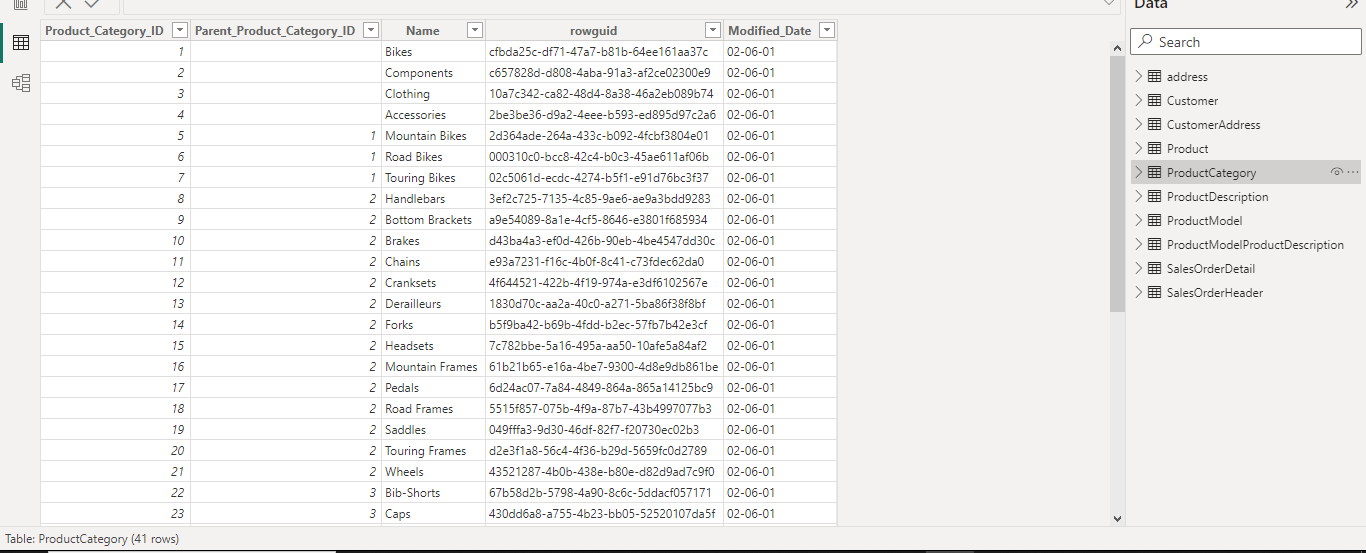
Image showing the transformation results in the columns

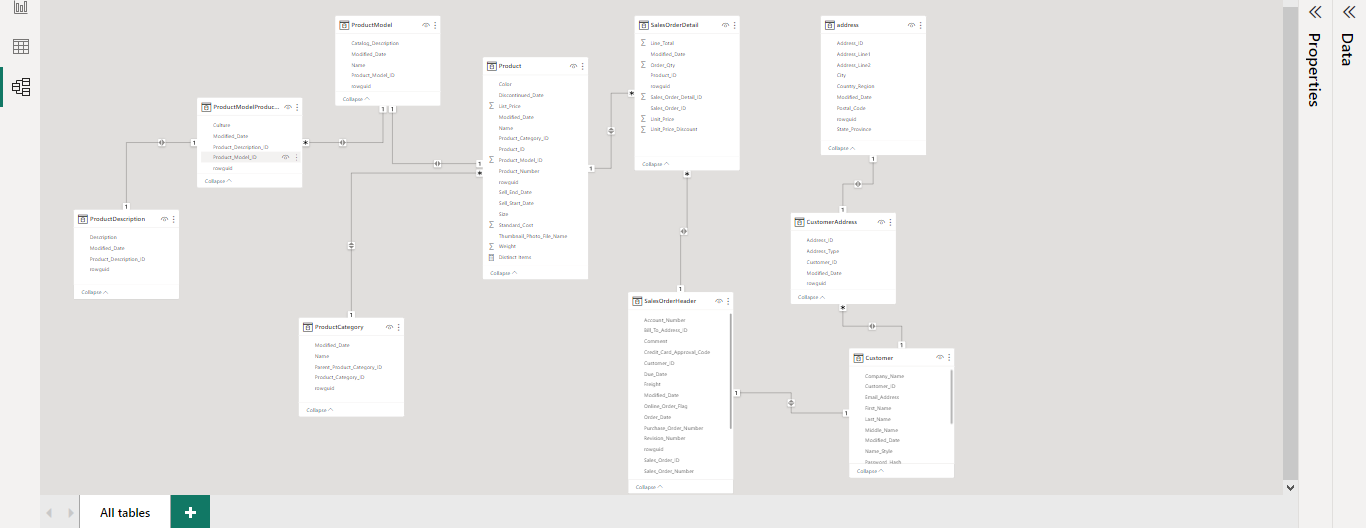
Image of the Data Model

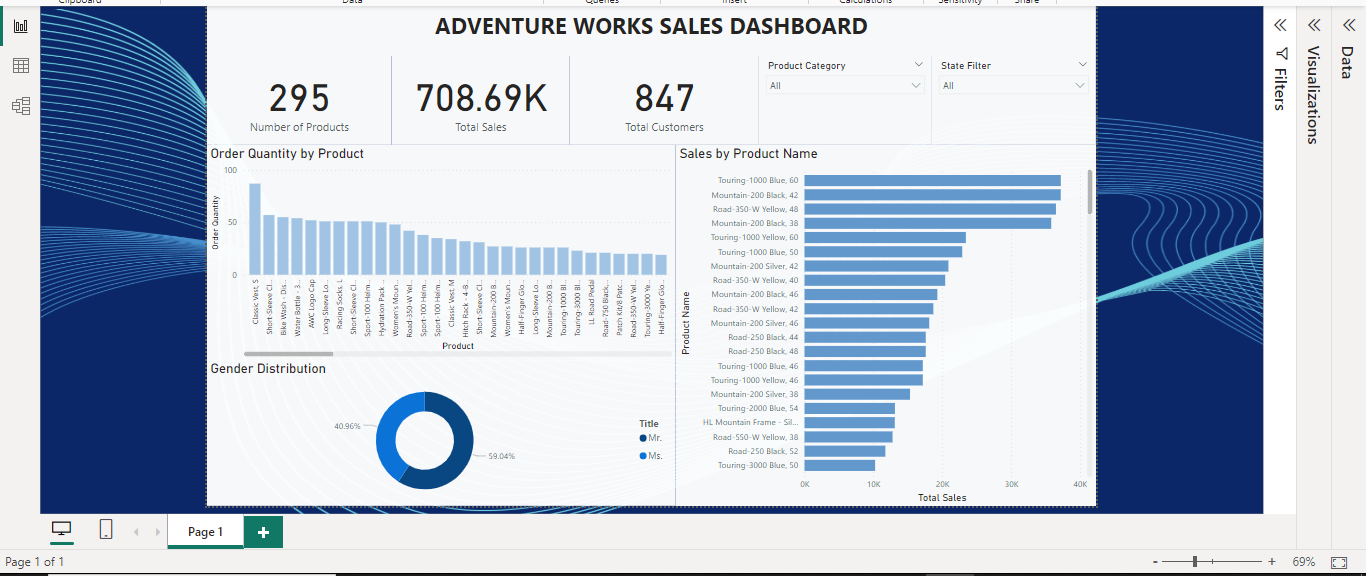
Image of the Dashboard

Power BI has a link to the Synapse serverless database, and any data change in the synapse views will reflect in the BI dashboard. The End to End testing of the pipeline will show it.

### Security and Governance: Azure Active Directory and Azure Key Vault
With Azure Active Directory (AAD), you can create a security group and assign permissions to the users in the security group. AAD is vital when working in teams, and members require access to available resources.

### Testing

- I will add a new row to the 'Customer' table in the on-premise sql server database.  
- I will use a scheduled trigger to run the pipeline (in ADF), and when I do, ADF will automatically connect to the on-prem database and copy all the data into the bronze container of azure data lake.  
- Databricks will collect the data from the bronze container, transform and insert them into the silver layer. It will perform another transformation and put the final data into the gold layer.  
- The clean data will then load into synapse analytics.  
- Power BI will then get the latest data from synapse analytics, reflecting the changes in the on-prem database.  

In [ ]:
%sql
--Inserting 2 new rows into the on premises server to test the ETL pipeline
--The change will be observed in the final report on the customer count card
-- Of course the data is not real. The details in the two added rows were randomly created for testing purposes. No personal information was exposed here.

USE [AdventureWorksLT2022]
GO

--To generate uniqueidentifiers for the rowguid column. Without doing this there was a uniqueidentifier error
SELECT NEWID()
GO


SET IDENTITY_INSERT [AdventureWorksLT2022].[SalesLT].[Customer] ON;

INSERT INTO [SalesLT].[Customer]
([CustomerID],[NameStyle]
,[Title]
,[FirstName]
,[MiddleName]
,[LastName]
,[Suffix]
,[CompanyName]
,[SalesPerson]
,[EmailAddress]
,[Phone]
,[PasswordHash]
,[PasswordSalt]
,[rowguid]
,[ModifiedDate])
VALUES
(595959,0,'Mr.','John','SR','Max','Jr.','xyz','adventure-works\John','John@gmail.com','13456-095-0045','L/Rlwxzp4w7RWmEgXX+/A7cXaAE768Fh2fJL7w=','1AFnbs4=',NEWID(),'07-05-03'),
(420845,0,'Mrs.','Jemima','Sikira','Ahmed','PhD.','SpaceX','adventure-works\Jemima','JemimaSA@gmail.com','14221-070-0325','L/Rpwejp4w7RWmEgXX+/A7cXaAi90MGEaQWFO=','1SSD657=',NEWID(),'06-04-015')



SET IDENTITY_INSERT [AdventureWorksLT2022].[SalesLT].[Customer] OFF
GO
;

--There is a mistake in the newly inserted data, ModifiedDate for 420845
--Use UPDATE to fix it. Did this for both rows
UPDATE [AdventureWorksLT2022].[SalesLT].[Customer]
SET ModifiedDate = '2007-05-03'
WHERE CustomerID = 420845

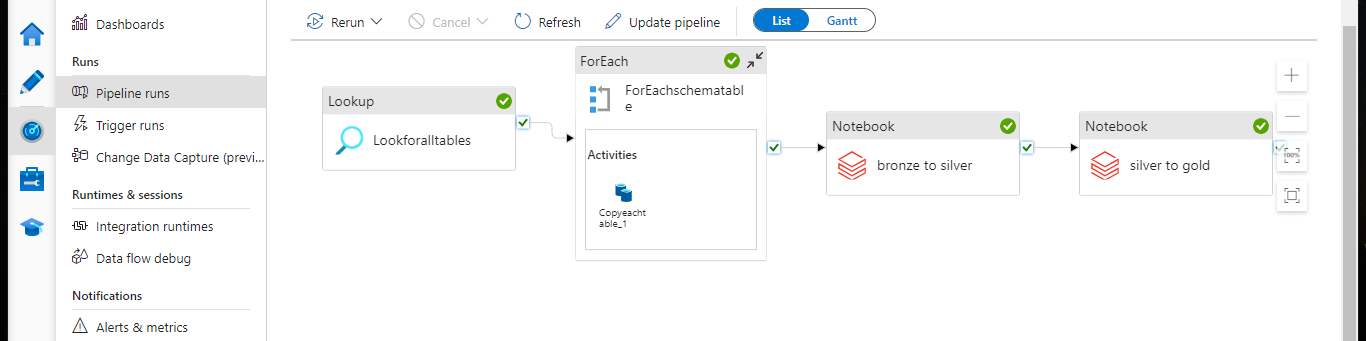
Pipeline Testing

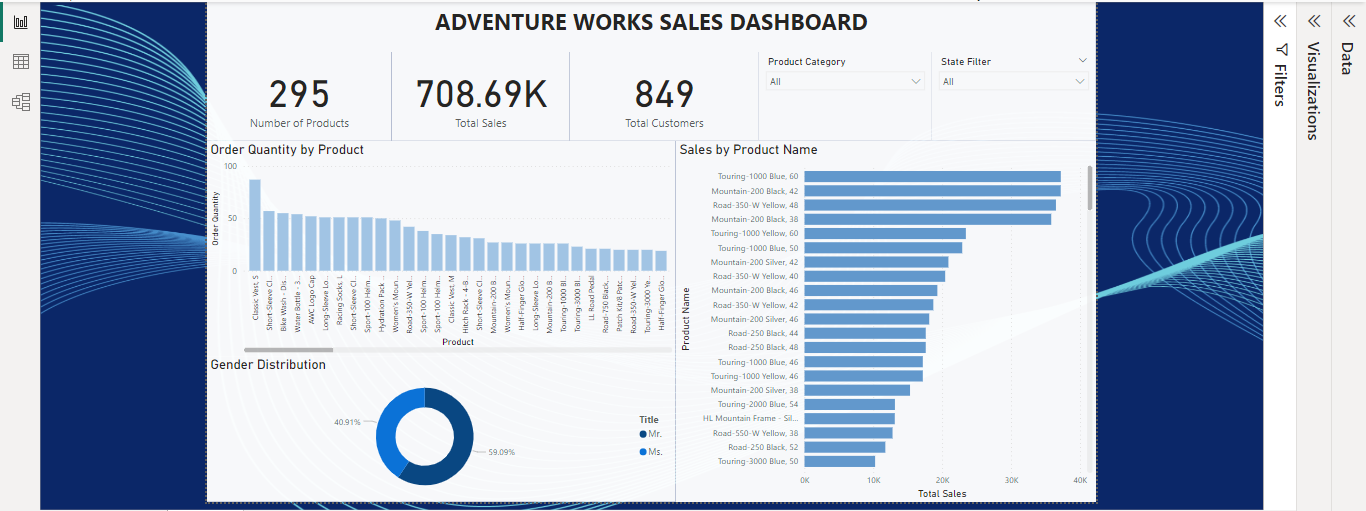
Change reflected in number of Total Customers